<a href="https://colab.research.google.com/github/hughesymendes/MandelbrotSet/blob/master/model_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**REQUIRED INPUTS TO BE CHANGED;**


 

1.   dipX name to include dip number
2.   clean_lc[:] to include cadence range
3.   T0 in cell 5,
4.   t = np.linspace(,,) in cell 5
5.   mu in cell 6


  

     |████████████████████████████████| 501kB 3.4MB/s 
     |████████████████████████████████| 4.5MB 11.1MB/s 
     |████████████████████████████████| 235kB 39.1MB/s 
     |████████████████████████████████| 25.2MB 1.6MB/s 
     |████████████████████████████████| 2.7MB 45.1MB/s 
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=8d81fea484c91eff79646130056ef65dd9a19d019cfec0a3571d9d5548181a57
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96456 sha256=522935ec2ca63b2115ea325d2691ef77b09be37c4c7ef831bf61049927a605d5
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=2523817b593cca9f27d9ba7794ac0542d84f394764f13a8e293a0e124415d4a6
  Stored in directory: /root/.cache/

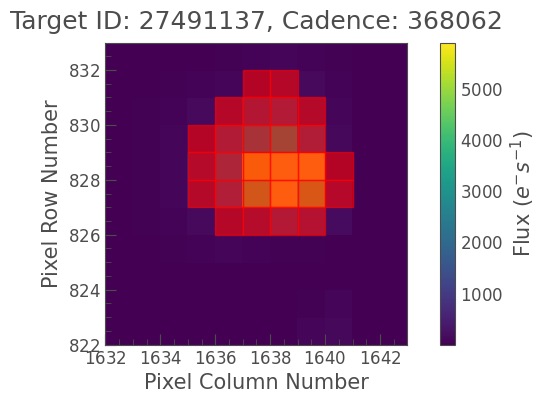

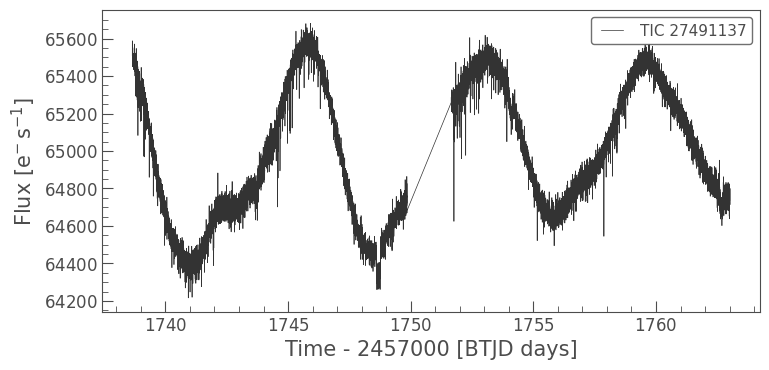

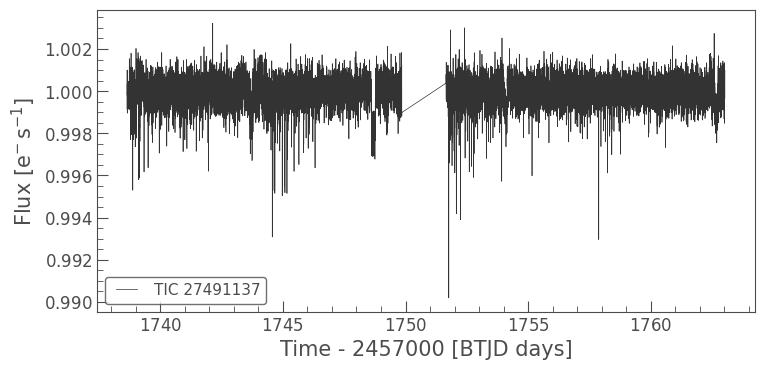

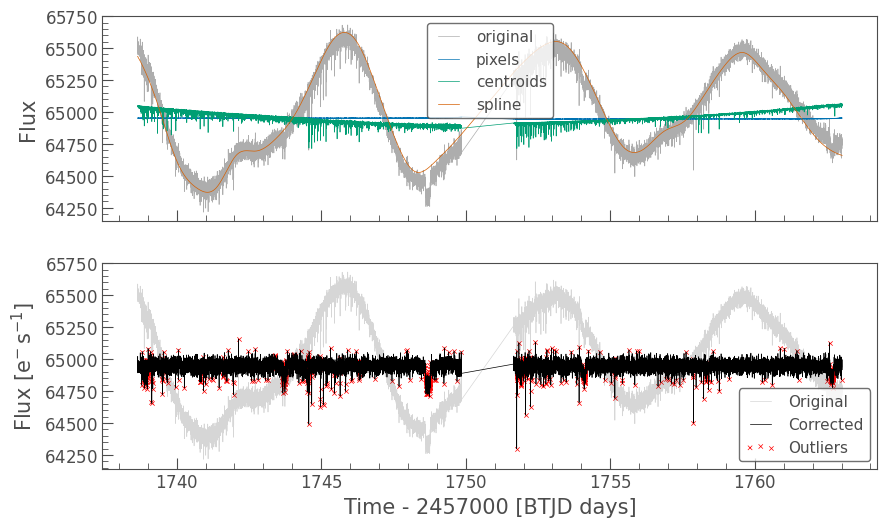

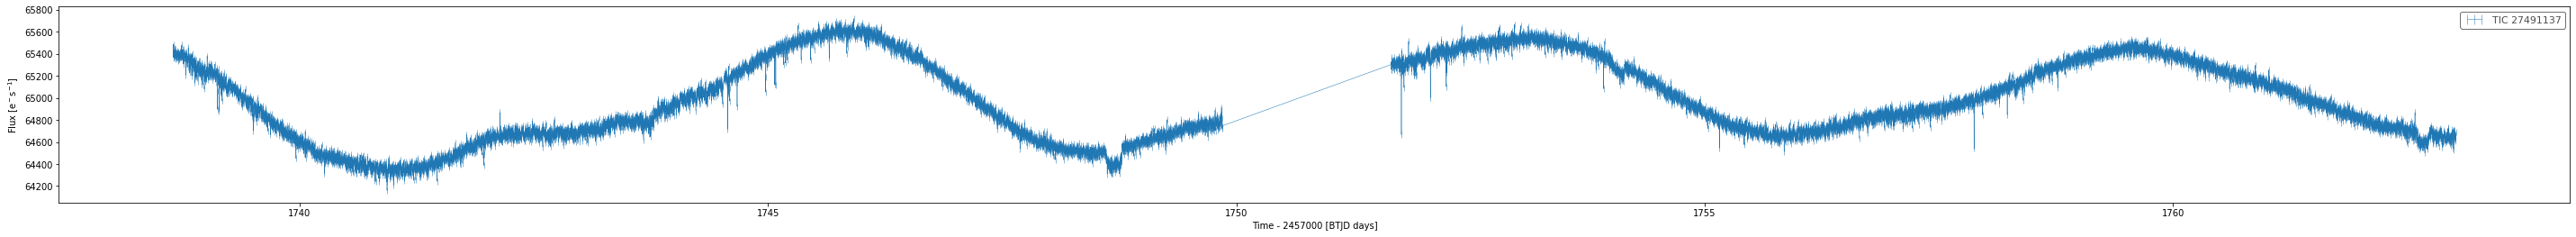

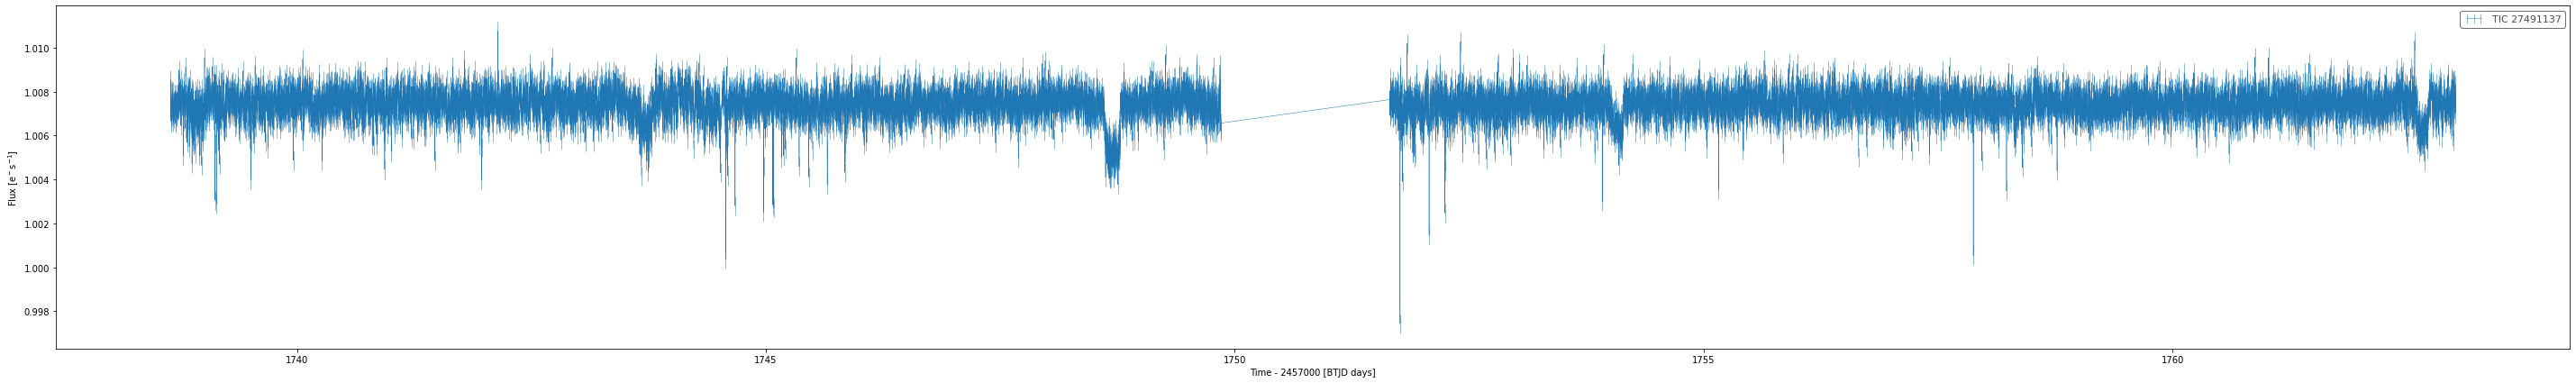

In [0]:
!pip install lightkurve

!pip install exoplanet

import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

In [0]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()

In [0]:
dipX = clean_lc[:]
dipX.plot()

In [0]:
d1x = np.append( np.array( [], dtype="float64" ),dip4.time )
d1y = np.append( np.array( [], dtype="float64" ), dip4.flux - 1.0075 )
d1y_err = np.append( np.array( [], dtype="float64" ), dip4.flux_err )

In [0]:
import numpy as np
import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=9.5, t0 =......, r_star = 0.78, m_star = 0.5)

# Compute a limb-darkened light curve using starry
t = np.linspace(.....,......,.....)
#found values from a paper for Kepler and TESS that gives a=0.4984, b= 0.1939 (using quadratic law).
# 'u' seems to be linear but is only given as one value whereas 'u' here is 2D so I've input values 
# In between the two closest stellar temps. paper-- https://arxiv.org/pdf/0912.2274.pdf

u = [0.525, 0.215]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.03, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=1)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [0]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    #Mu seems to be centre of transit.
    #For random.uniform "Samples are uniformly distributed over the half-open interval [low, high) (includes low, but excludes high)"
    t0 = pm.Normal("t0", mu=........, sd=1.0, shape=1)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.random.uniform(1,50,1), sd=0.1, shape=1)
    period = np.random.uniform(1,50,1)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.04, 0.06]))

    r = pm.Uniform("r", lower=0.02, upper=0.03, shape=1)
    b = xo.distributions.ImpactParameter("b", ror=r, shape=1, testval=np.random.rand())

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = d1y
    y += d1y_err * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=d1y_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

In [0]:
plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")